#Improving Market Basket Analysis results using topic modelling.

Aim : To prove why a probabilistic approach is better at improving Market Basket analysis results than a mathematical approach.
So in our project LDA represents a probabilistic approach and K-Means represents a mathematical approach.

## Importing required packages and initiating Spark session

In [ ]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 69kB/s 
     |████████████████████████████████| 204kB 42.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=748e54fb74207e9d8890ac32c0c637298040b9aac4e374cd2f82c8f8095023a0
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [ ]:
import pandas as pd

aisles_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/aisles.csv')
departments_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/departments.csv')
orders_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/orders.csv')
products_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/products.csv')
order_product_prior_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/order_products__prior.csv')
order_product_train_df = pd.read_csv('/content/drive/MyDrive/DS 5230 Project/order_products__train.csv')

In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.mllib.fpm import FPGrowth
SparkContext.setSystemProperty('spark.executor.memory', '16g'),('spark.driver.memory', '10g'),('spark.driver.maxResultSize', '10g') ## adjust the required memory to your computational resource!
sc = pyspark.SparkContext()


In [ ]:
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)
from pyspark.sql.functions import split

In [ ]:
## others 
import re 
import matplotlib.pyplot as plt 
import numpy as np
import math
import pandas as pd

## Applying Apriori algorithm to the user segment

### Getting users who have ordered less than 15 times

In [ ]:
import pickle
user_bag_of_products_15 =pickle.load( open( "/content/drive/MyDrive/DS 5230 Project/LessThan15.p", "rb" ) )


In [ ]:
import pickle
user_bag_of_products =pickle.load( open( "/content/drive/MyDrive/DS 5230 Project/Pickle Files/user_bag_of_products.p", "rb" ) )


In [ ]:
len(user_bag_of_products) 

205232

In [ ]:
user_bag_of_products

[['Bag of Organic Bananas',
  'Bag of Organic Bananas',
  'Organic Half & Half',
  'Organic Half & Half',
  'Organic Unsweetened Almond Milk',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Soda',
  'Bartlett Pears',
  'Creamy Almond Butter',
  'Organic Unsweetened Vanilla Almond Milk',
  'Honeycrisp Apples',
  '0% Greek Strained Yogurt',
  'Zero Calorie Cola',
  'Zero Calorie Cola',
  'Zero Calorie Cola',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Original Beef Jerky',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic String Cheese',
  'Organic Fuji Apples',
  'Milk Chocolate Almonds'],
 ['Banana',
  'Banana',


In [ ]:
len((user_bag_of_products_15))

136320

In [ ]:
user_bag_of_products_15.unique()

array([     1,      2,      3, ..., 206204, 206205, 206209])

In [ ]:
type(user_bag_of_products_15)

pandas.core.series.Series

In [ ]:
sbc = user_bag_of_products_15.to_frame()

sbc

Unnamed: 0
0                1
1                2
2                3
3                4
4                5
...            ...
206197      206198
206202      206203
206203      206204
206204      206205
206208      206209

[136320 rows x 1 columns]

In [ ]:
tbc = sbc.rename(columns={"Unnamed: 0":"user_id"})  

In [ ]:
ubc = tbc.reset_index()

In [ ]:
del ubc["index"]

In [ ]:
ubc

user_id
0             1
1             2
2             3
3             4
4             5
...         ...
136315   206198
136316   206203
136317   206204
136318   206205
136319   206209

[136320 rows x 1 columns]

In [ ]:
unique_user_15_cluster_df = ubc

In [ ]:
unique_user_15_cluster_orders_df = unique_user_15_cluster_df.merge(orders_df,how = 'inner',on = 'user_id')

In [ ]:
unique_user_15_cluster_orders_df = unique_user_15_cluster_orders_df[unique_user_15_cluster_orders_df["eval_set"]=="prior"]

In [ ]:
unique_user_15_cluster_orders_df

user_id  order_id  ... order_hour_of_day  days_since_prior_order
0              1   2539329  ...                 8                     NaN
1              1   2398795  ...                 7                    15.0
2              1    473747  ...                12                    21.0
3              1   2254736  ...                 7                    29.0
4              1    431534  ...                15                    28.0
...          ...       ...  ...               ...                     ...
1070362   206209   2558525  ...                15                    22.0
1070363   206209   2266710  ...                18                    29.0
1070364   206209   1854736  ...                10                    30.0
1070365   206209    626363  ...                12                    18.0
1070366   206209   2977660  ...                12                     7.0

[934048 rows x 7 columns]

In [ ]:
unique_user_15_cluster_orders_prod_df = unique_user_15_cluster_orders_df.merge(order_product_prior_df,how = 'inner', on = 'order_id')

In [ ]:
unique_user_15_cluster_orders_prod_df

user_id  order_id eval_set  ...  product_id  add_to_cart_order  reordered
0              1   2539329    prior  ...         196                  1          0
1              1   2539329    prior  ...       14084                  2          0
2              1   2539329    prior  ...       12427                  3          0
3              1   2539329    prior  ...       26088                  4          0
4              1   2539329    prior  ...       26405                  5          0
...          ...       ...      ...  ...         ...                ...        ...
9236219   206209   2977660    prior  ...       14197                  5          1
9236220   206209   2977660    prior  ...       38730                  6          0
9236221   206209   2977660    prior  ...       31477                  7          0
9236222   206209   2977660    prior  ...        6567                  8          0
9236223   206209   2977660    prior  ...       22920                  9          0

[9236224 rows x 10 columns]

In [ ]:
unique_user_15_cluster_orders_prod_name_df = unique_user_15_cluster_orders_prod_df.merge(products_df,how='left',on = 'product_id')

In [ ]:
unique_user_15_cluster_orders_prod_name_df

user_id  order_id  ... aisle_id  department_id
0              1   2539329  ...       77              7
1              1   2539329  ...       91             16
2              1   2539329  ...       23             19
3              1   2539329  ...       23             19
4              1   2539329  ...       54             17
...          ...       ...  ...      ...            ...
9236219   206209   2977660  ...        9              9
9236220   206209   2977660  ...        3             19
9236221   206209   2977660  ...        3             19
9236222   206209   2977660  ...        3             19
9236223   206209   2977660  ...      117             19

[9236224 rows x 13 columns]

In [ ]:
unique_user_15_cluster_orders_prod_name_df = unique_user_15_cluster_orders_prod_name_df[["user_id","order_id","product_name"]]
unique_user_15_cluster_orders_prod_name_df

user_id  order_id                             product_name
0              1   2539329                                     Soda
1              1   2539329  Organic Unsweetened Vanilla Almond Milk
2              1   2539329                      Original Beef Jerky
3              1   2539329               Aged White Cheddar Popcorn
4              1   2539329         XL Pick-A-Size Paper Towel Rolls
...          ...       ...                                      ...
9236219   206209   2977660                             Tomato Paste
9236220   206209   2977660          Brownie Crunch High Protein Bar
9236221   206209   2977660    High Protein Bar Chunky Peanut Butter
9236222   206209   2977660      Chocolate Peanut Butter Protein Bar
9236223   206209   2977660      Roasted & Salted Shelled Pistachios

[9236224 rows x 3 columns]

In [ ]:
len(unique_user_15_cluster_orders_prod_name_df['product_name'].unique())

48773

In [ ]:
# frequency count of column A
count = unique_user_15_cluster_orders_prod_name_df['product_name'].value_counts().reset_index()
count.columns= ["product_name","frequency_count"]

### Selecting products on basis of frequency count, only selecting products with frequency count more than 800

In [ ]:
abc = count[count["frequency_count"]>800]
abc

product_name  frequency_count
0                                               Banana           127102
1                               Bag of Organic Bananas            88272
2                                 Organic Baby Spinach            65100
3                                 Organic Strawberries            59016
4                                      Organic Avocado            53975
...                                                ...              ...
2090                Chicken Pad Thai With Rice Noodles              802
2091                           Organic Cheddar Bunnies              802
2092  Lemongrass & Clementine Zest Natural Dish Liquid              801
2093                   Original Roasted Seaweed Snacks              801
2094                                         Diet Cola              801

[2095 rows x 2 columns]

20


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


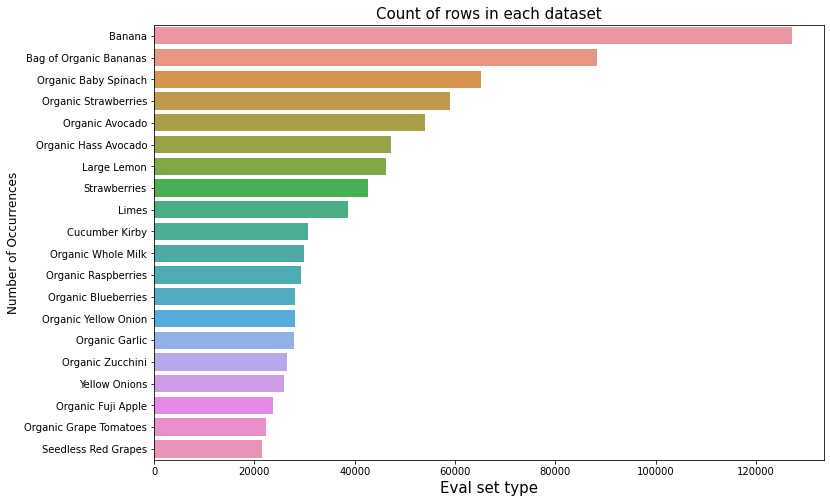

In [ ]:
import seaborn as sns

total_abc=abc.head(20)
print(len(total_abc["product_name"].unique()))

total_cnt_srs = total_abc
plt.figure(figsize=(12,8))
sns.barplot(total_cnt_srs.frequency_count, total_cnt_srs.product_name)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=15)
plt.title('Count of rows in each dataset', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

In [ ]:
unique_user_15_cluster_orders_prod_name_df_refined=pd.merge(unique_user_15_cluster_orders_prod_name_df, abc, on='product_name', how='right')

In [ ]:
unique_user_15_cluster_orders_prod_name_df_refined

user_id  order_id product_name  frequency_count
0              2    738281       Banana           127102
1              2   1199898       Banana           127102
2              2   3194192       Banana           127102
3              2    788338       Banana           127102
4              2   1718559       Banana           127102
...          ...       ...          ...              ...
5921988   204819   1484972    Diet Cola              801
5921989   205969    978697    Diet Cola              801
5921990   205969   1768348    Diet Cola              801
5921991   205969   1213279    Diet Cola              801
5921992   205969   2103068    Diet Cola              801

[5921993 rows x 4 columns]

In [ ]:
len(unique_user_15_cluster_orders_prod_name_df_refined['order_id'].unique())

887118

In [ ]:
ordered_15_product_name_df_basket = unique_user_15_cluster_orders_prod_name_df_refined.groupby('user_id')['product_name'].apply(list)
ordered_15_product_name_df_new_basket = ordered_15_product_name_df_basket
ordered_15_product_name_df_new_basket
user_baskets_15 = list(ordered_15_product_name_df_new_basket)

### Arranging the product list in a basket form, where each basket is an user and here the items in basket are products.

In [ ]:
len(user_baskets_15)

135824

In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pickle

In [ ]:
te_in_15 = TransactionEncoder()
te_ary_insta_15 = te_in_15.fit(user_baskets_15).transform(user_baskets_15)
insta_apriori_15 = pd.DataFrame(te_ary_insta_15, columns=te_in_15.columns_)
insta_apriori_15

0% Fat Free Organic Milk  ...  with Crispy Almonds Cereal
0                          False  ...                       False
1                          False  ...                       False
2                          False  ...                       False
3                          False  ...                       False
4                          False  ...                       False
...                          ...  ...                         ...
135819                     False  ...                       False
135820                     False  ...                       False
135821                     False  ...                       False
135822                     False  ...                       False
135823                     False  ...                       False

[135824 rows x 2095 columns]

### Support is kept as 0.05, so this means that the product which is included in the frequent itemset, constitutes to minimum 5% of the total orders.

In [ ]:
a_rules = apriori(insta_apriori_15, min_support = 0.05, use_colnames = True)

rules_15_after_lda_proper = association_rules(a_rules, metric = 'confidence', min_threshold = 0.1)
rules_15_after_lda_proper

antecedents               consequents  ...  leverage  conviction
0     (Organic Baby Spinach)  (Bag of Organic Bananas)  ...  0.027685    1.214492
1   (Bag of Organic Bananas)    (Organic Baby Spinach)  ...  0.027685    1.175426
2     (Organic Hass Avocado)  (Bag of Organic Bananas)  ...  0.030204    1.369023
3   (Bag of Organic Bananas)    (Organic Hass Avocado)  ...  0.030204    1.178841
4     (Organic Strawberries)  (Bag of Organic Bananas)  ...  0.032611    1.268608
5   (Bag of Organic Bananas)    (Organic Strawberries)  ...  0.032611    1.212143
6                   (Banana)          (Cucumber Kirby)  ...  0.025124    1.103560
7           (Cucumber Kirby)                  (Banana)  ...  0.025124    1.483891
8                   (Banana)             (Large Lemon)  ...  0.027650    1.124464
9              (Large Lemon)                  (Banana)  ...  0.027650    1.303750
10                   (Limes)                  (Banana)  ...  0.020009    1.226118
11                  (Banana)                   (Limes)  ...  0.020009    1.085444
12         (Organic Avocado)                  (Banana)  ...  0.027886    1.320740
13                  (Banana)         (Organic Avocado)  ...  0.027886    1.124728
14                  (Banana)    (Organic Baby Spinach)  ...  0.013930    1.061788
15    (Organic Baby Spinach)                  (Banana)  ...  0.013930    1.107998
16                  (Banana)    (Organic Strawberries)  ...  0.015365    1.068263
17    (Organic Strawberries)                  (Banana)  ...  0.015365    1.122869
18            (Strawberries)                  (Banana)  ...  0.025883    1.312626
19                  (Banana)            (Strawberries)  ...  0.025883    1.113406
20           (Yellow Onions)                  (Banana)  ...  0.021352    1.385954
21                  (Banana)           (Yellow Onions)  ...  0.021352    1.086608
22                   (Limes)             (Large Lemon)  ...  0.035875    1.385865
23             (Large Lemon)                   (Limes)  ...  0.035875    1.333610
24         (Organic Avocado)             (Large Lemon)  ...  0.026600    1.242330
25             (Large Lemon)         (Organic Avocado)  ...  0.026600    1.230753
26    (Organic Baby Spinach)             (Large Lemon)  ...  0.020628    1.138356
27             (Large Lemon)    (Organic Baby Spinach)  ...  0.020628    1.180267
28                   (Limes)         (Organic Avocado)  ...  0.026916    1.261857
29         (Organic Avocado)                   (Limes)  ...  0.026916    1.240655
30                   (Limes)    (Organic Baby Spinach)  ...  0.022449    1.222218
31    (Organic Baby Spinach)                   (Limes)  ...  0.022449    1.149412
32         (Organic Avocado)    (Organic Baby Spinach)  ...  0.030721    1.307353
33    (Organic Baby Spinach)         (Organic Avocado)  ...  0.030721    1.219242
34         (Organic Avocado)    (Organic Strawberries)  ...  0.020109    1.180915
35    (Organic Strawberries)         (Organic Avocado)  ...  0.020109    1.136101
36    (Organic Baby Spinach)          (Organic Garlic)  ...  0.029606    1.195635
37          (Organic Garlic)    (Organic Baby Spinach)  ...  0.029606    1.479350
38    (Organic Hass Avocado)    (Organic Baby Spinach)  ...  0.026372    1.293406
39    (Organic Baby Spinach)    (Organic Hass Avocado)  ...  0.026372    1.177974
40    (Organic Strawberries)    (Organic Baby Spinach)  ...  0.030528    1.236171
41    (Organic Baby Spinach)    (Organic Strawberries)  ...  0.030528    1.229822
42    (Organic Strawberries)     (Organic Blueberries)  ...  0.027912    1.187261
43     (Organic Blueberries)    (Organic Strawberries)  ...  0.027912    1.415873
44    (Organic Hass Avocado)    (Organic Strawberries)  ...  0.027291    1.304983
45    (Organic Strawberries)    (Organic Hass Avocado)  ...  0.027291    1.189246

[46 rows x 9 columns]

In [ ]:
rules_15_after_lda_proper.sort_values(by=['lift'])

antecedents               consequents  ...  leverage  conviction
15    (Organic Baby Spinach)                  (Banana)  ...  0.013930    1.107998
14                  (Banana)    (Organic Baby Spinach)  ...  0.013930    1.061788
16                  (Banana)    (Organic Strawberries)  ...  0.015365    1.068263
17    (Organic Strawberries)                  (Banana)  ...  0.015365    1.122869
10                   (Limes)                  (Banana)  ...  0.020009    1.226118
11                  (Banana)                   (Limes)  ...  0.020009    1.085444
9              (Large Lemon)                  (Banana)  ...  0.027650    1.303750
8                   (Banana)             (Large Lemon)  ...  0.027650    1.124464
18            (Strawberries)                  (Banana)  ...  0.025883    1.312626
19                  (Banana)            (Strawberries)  ...  0.025883    1.113406
13                  (Banana)         (Organic Avocado)  ...  0.027886    1.124728
12         (Organic Avocado)                  (Banana)  ...  0.027886    1.320740
1   (Bag of Organic Bananas)    (Organic Baby Spinach)  ...  0.027685    1.175426
0     (Organic Baby Spinach)  (Bag of Organic Bananas)  ...  0.027685    1.214492
27             (Large Lemon)    (Organic Baby Spinach)  ...  0.020628    1.180267
26    (Organic Baby Spinach)             (Large Lemon)  ...  0.020628    1.138356
34         (Organic Avocado)    (Organic Strawberries)  ...  0.020109    1.180915
35    (Organic Strawberries)         (Organic Avocado)  ...  0.020109    1.136101
20           (Yellow Onions)                  (Banana)  ...  0.021352    1.385954
21                  (Banana)           (Yellow Onions)  ...  0.021352    1.086608
5   (Bag of Organic Bananas)    (Organic Strawberries)  ...  0.032611    1.212143
4     (Organic Strawberries)  (Bag of Organic Bananas)  ...  0.032611    1.268608
31    (Organic Baby Spinach)                   (Limes)  ...  0.022449    1.149412
30                   (Limes)    (Organic Baby Spinach)  ...  0.022449    1.222218
40    (Organic Strawberries)    (Organic Baby Spinach)  ...  0.030528    1.236171
41    (Organic Baby Spinach)    (Organic Strawberries)  ...  0.030528    1.229822
6                   (Banana)          (Cucumber Kirby)  ...  0.025124    1.103560
7           (Cucumber Kirby)                  (Banana)  ...  0.025124    1.483891
39    (Organic Baby Spinach)    (Organic Hass Avocado)  ...  0.026372    1.177974
38    (Organic Hass Avocado)    (Organic Baby Spinach)  ...  0.026372    1.293406
2     (Organic Hass Avocado)  (Bag of Organic Bananas)  ...  0.030204    1.369023
3   (Bag of Organic Bananas)    (Organic Hass Avocado)  ...  0.030204    1.178841
32         (Organic Avocado)    (Organic Baby Spinach)  ...  0.030721    1.307353
33    (Organic Baby Spinach)         (Organic Avocado)  ...  0.030721    1.219242
45    (Organic Strawberries)    (Organic Hass Avocado)  ...  0.027291    1.189246
44    (Organic Hass Avocado)    (Organic Strawberries)  ...  0.027291    1.304983
24         (Organic Avocado)             (Large Lemon)  ...  0.026600    1.242330
25             (Large Lemon)         (Organic Avocado)  ...  0.026600    1.230753
28                   (Limes)         (Organic Avocado)  ...  0.026916    1.261857
29         (Organic Avocado)                   (Limes)  ...  0.026916    1.240655
42    (Organic Strawberries)     (Organic Blueberries)  ...  0.027912    1.187261
43     (Organic Blueberries)    (Organic Strawberries)  ...  0.027912    1.415873
36    (Organic Baby Spinach)          (Organic Garlic)  ...  0.029606    1.195635
37          (Organic Garlic)    (Organic Baby Spinach)  ...  0.029606    1.479350
22                   (Limes)             (Large Lemon)  ...  0.035875    1.385865
23             (Large Lemon)                   (Limes)  ...  0.035875    1.333610

[46 rows x 9 columns]

## Applying K-means to user segment to divide the user segment into futher user clusters using a mathematical approach

In [ ]:
from pyspark.sql import Row
R = Row('ID', 'products')

# use enumerate to add the ID column
spark_df_user_15_bag_of_products=spark.createDataFrame([R(i, x) for i, x in enumerate(user_baskets_15)])

In [ ]:
spark_df_user_15_bag_of_products.show()

+---+--------------------+
| ID|            products|
+---+--------------------+
|  0|[Bag of Organic B...|
|  1|[Banana, Banana, ...|
|  2|[Organic Baby Spi...|
|  3|[Organic Gala App...|
|  4|[Organic Grape To...|
|  5|[Organic Baby Spi...|
|  6|[Organic Baby Spi...|
|  7|[Organic Raspberr...|
|  8|[Banana, Large Le...|
|  9|[Bag of Organic B...|
| 10|[Bag of Organic B...|
| 11|[Half & Half, Hal...|
| 12|[Limes, Honeycris...|
| 13|[Banana, Banana, ...|
| 14|[Organic Strawber...|
| 15|[Blueberries, Sod...|
| 16|[Granny Smith App...|
| 17|[Clementines, Bag...|
| 18|[Organic Lacinato...|
| 19|[Sparkling Water ...|
+---+--------------------+
only showing top 20 rows



In [ ]:
print((spark_df_user_15_bag_of_products.count(), len(spark_df_user_15_bag_of_products.columns)))

(135824, 2)


In [ ]:
%matplotlib inline
## pyspark imports 
import pyspark 
from pyspark import SparkContext
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover, IDF, RegexTokenizer
from pyspark.sql import SparkSession

In [ ]:
cv = CountVectorizer(inputCol="products", outputCol="features", vocabSize=2095)

cv_model_15 = cv.fit(spark_df_user_15_bag_of_products)

title_Count_15 = cv_model_15.transform(spark_df_user_15_bag_of_products)

In [ ]:
title_Count_15.count()

135824

In [ ]:
title_Count_15.show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=10, seed=1)
model = kmeans.fit(title_Count_15.select('features'))

In [ ]:
transformed = model.transform(title_Count_15)
transformed.show() 

+---+--------------------+--------------------+----------+
| ID|            products|            features|prediction|
+---+--------------------+--------------------+----------+
|  0|[Bag of Organic B...|(2095,[1,36,61,75...|         1|
|  1|[Banana, Banana, ...|(2095,[0,1,4,5,7,...|         3|
|  2|[Organic Baby Spi...|(2095,[2,3,4,7,9,...|         0|
|  3|[Organic Gala App...|(2095,[45,46,113,...|         1|
|  4|[Organic Grape To...|(2095,[18,25,28,3...|         1|
|  5|[Organic Baby Spi...|(2095,[2,15,62,67...|         1|
|  6|[Organic Baby Spi...|(2095,[2,27,31,63...|         1|
|  7|[Organic Raspberr...|(2095,[11,43,105,...|         1|
|  8|[Banana, Large Le...|(2095,[0,6,7,8,15...|         5|
|  9|[Bag of Organic B...|(2095,[1,8,22,31,...|         1|
| 10|[Bag of Organic B...|(2095,[1,9,13,20,...|         8|
| 11|[Half & Half, Hal...|(2095,[47,48,87,9...|         1|
| 12|[Limes, Honeycris...|(2095,[8,21,24,28...|         1|
| 13|[Banana, Banana, ...|(2095,[0,2,3,18,2...|         

In [ ]:
transformed.select("prediction").count()

135824

In [ ]:
k_means_cluster_list = transformed.select("prediction").toPandas()

In [ ]:
k_means_cluster_list

prediction
0                1
1                3
2                0
3                1
4                1
...            ...
135819           1
135820           1
135821           1
135822           1
135823           8

[135824 rows x 1 columns]

In [ ]:
type( (unique_user_15_cluster_orders_prod_name_df_refined['user_id'].unique()))

numpy.ndarray

In [ ]:
user_list = pd.DataFrame(unique_user_15_cluster_orders_prod_name_df_refined['user_id'].unique(), columns = ['user_id'])

In [ ]:
user_list

user_id
0             2
1            10
2            16
3            32
4            35
...         ...
135819    59694
135820    72419
135821   112273
135822    30934
135823   116001

[135824 rows x 1 columns]

In [ ]:
user_clusters_k_means = pd.concat([user_list, k_means_cluster_list], axis=1)

In [ ]:
user_clusters_k_means

user_id  prediction
0             2           1
1            10           3
2            16           0
3            32           1
4            35           1
...         ...         ...
135819    59694           1
135820    72419           1
135821   112273           1
135822    30934           1
135823   116001           8

[135824 rows x 2 columns]

In [ ]:
user_count_each_kmeans_cluster = user_clusters_k_means.groupby("prediction").count()
user_count_each_kmeans_cluster

user_id
prediction         
0              4884
1             77495
2             15960
3              5215
4              2579
5              8324
6              6621
7              2480
8              8541
9              3725

### Evaluating K means clustering method using Silhouette score 

In [ ]:
#evaluator = ClusteringEvaluator()

#silhouette = evaluator.evaluate(transformed)
#print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
#centers = model.clusterCenters()
#print("Cluster Centers: ")
#for center in centers:
#    print(center)

## Applying LDA to user segment to divide the user segment into futher user clusters using a probabilistic approach

### Getting count vectorizer ready

In [ ]:
spark_df_user_15_bag_of_products.show()

+---+--------------------+
| ID|            products|
+---+--------------------+
|  0|[Bag of Organic B...|
|  1|[Banana, Banana, ...|
|  2|[Organic Baby Spi...|
|  3|[Organic Gala App...|
|  4|[Organic Grape To...|
|  5|[Organic Baby Spi...|
|  6|[Organic Baby Spi...|
|  7|[Organic Raspberr...|
|  8|[Banana, Large Le...|
|  9|[Bag of Organic B...|
| 10|[Bag of Organic B...|
| 11|[Half & Half, Hal...|
| 12|[Limes, Honeycris...|
| 13|[Banana, Banana, ...|
| 14|[Organic Strawber...|
| 15|[Blueberries, Sod...|
| 16|[Granny Smith App...|
| 17|[Clementines, Bag...|
| 18|[Organic Lacinato...|
| 19|[Sparkling Water ...|
+---+--------------------+
only showing top 20 rows



In [ ]:
spark_df_user_15_bag_of_products.count()

135824

In [ ]:
%matplotlib inline
## pyspark imports 
import pyspark 
from pyspark import SparkContext
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover, IDF, RegexTokenizer
from pyspark.sql import SparkSession

cv = CountVectorizer(inputCol="products", outputCol="features", vocabSize=2095)

cv_model_15 = cv.fit(spark_df_user_15_bag_of_products)

title_Count_15_lda = cv_model_15.transform(spark_df_user_15_bag_of_products)

In [ ]:
# doing this for 1.c part, creating a dictionary of dimensions, which in this case are words
dimensions = {}
count = 0
for i in cv_model_15.vocabulary:
    dimensions[count] = i
    count += 1

In [ ]:
title_Count_15_lda.show()

+---+--------------------+--------------------+
| ID|            products|            features|
+---+--------------------+--------------------+
|  0|[Bag of Organic B...|(2095,[1,36,61,75...|
|  1|[Banana, Banana, ...|(2095,[0,1,4,5,7,...|
|  2|[Organic Baby Spi...|(2095,[2,3,4,7,9,...|
|  3|[Organic Gala App...|(2095,[45,46,113,...|
|  4|[Organic Grape To...|(2095,[18,25,28,3...|
|  5|[Organic Baby Spi...|(2095,[2,15,62,67...|
|  6|[Organic Baby Spi...|(2095,[2,27,31,63...|
|  7|[Organic Raspberr...|(2095,[11,43,105,...|
|  8|[Banana, Large Le...|(2095,[0,6,7,8,15...|
|  9|[Bag of Organic B...|(2095,[1,8,22,31,...|
| 10|[Bag of Organic B...|(2095,[1,9,13,20,...|
| 11|[Half & Half, Hal...|(2095,[47,48,87,9...|
| 12|[Limes, Honeycris...|(2095,[8,21,24,28...|
| 13|[Banana, Banana, ...|(2095,[0,2,3,18,2...|
| 14|[Organic Strawber...|(2095,[3,8,20,28,...|
| 15|[Blueberries, Sod...|(2095,[35,75,82,1...|
| 16|[Granny Smith App...|(2095,[82,118,579...|
| 17|[Clementines, Bag...|(2095,[77,87,1

### Keeping k = 10, so there are ten topics, so we get perplexity for this.

In [ ]:
from pyspark.ml.clustering import LDA
# Trains a LDA model.
lda_10 = LDA(k=10, maxIter=10)
model_lda_k_10 = lda_10.fit(title_Count_15_lda)

ll = model_lda_k_10.logLikelihood(title_Count_15_lda)
lp = model_lda_k_10.logPerplexity(title_Count_15_lda)
print("The lower bound on the log likelihood of the entire corpus for k = 10: " + str(ll))
print("The upper bound on perplexity for k = 10: " + str(lp))

The lower bound on the log likelihood of the entire corpus for k = 10: -39934288.726299
The upper bound on perplexity for k = 10: 6.743386681865211


In [ ]:
perplexity_dict = {}
perplexity_dict[10] = lp

In [ ]:
# Describe topics.
topics = model_lda_k_10.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

The topics described by their top-weighted terms:
+-----+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                    |termWeights                                                                                                                                                                                                                 |
+-----+-----------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[1, 11, 3, 74, 107, 430, 382, 90, 46, 492]     |[0.02281383256107343, 0.019135880353089853, 0.01487804141461262,

In [ ]:
termIndices = topics.select('termIndices').collect()
termIndices = list(topics.select('termIndices').toPandas()['termIndices'])

In [ ]:
(termIndices)

[[1, 11, 3, 74, 107, 430, 382, 90, 46, 492],
 [0, 1, 63, 12, 6, 4, 2, 8, 122, 65],
 [1, 53, 7, 34, 2, 118, 3, 75, 233, 12],
 [0, 6, 7, 16, 66, 154, 1, 48, 82, 57],
 [0, 7, 1, 37, 163, 102, 168, 151, 284, 17],
 [0, 87, 7, 70, 37, 4, 57, 35, 350, 17],
 [49, 69, 127, 8, 6, 419, 75, 102, 0, 25],
 [2, 1, 0, 4, 3, 5, 6, 8, 14, 10],
 [0, 5, 1, 3, 22, 17, 4, 2, 64, 11],
 [171, 303, 75, 258, 223, 253, 436, 673, 1, 468]]

In [ ]:
topic = {}
for i in range(len(termIndices)):
  for n in termIndices[i]:
    if i not in topic:
      topic[i]=[dimensions[n]]
    else:
      topic[i].append(dimensions[n])
    

In [ ]:
len(dimensions)

2095

In [ ]:
print('Top 10 products in top 10 topics: ')
for i in range(len(topic)):
  print(i+1,topic[i])
#topic

Top 10 products in top 10 topics: 
1 ['Bag of Organic Bananas', 'Organic Raspberries', 'Organic Strawberries', 'Uncured Genoa Salami', '100% Raw Coconut Water', 'Blueberry Yoghurt', 'Milk, Organic, Vitamin D', 'Organic Reduced Fat 2% Milk', 'Organic Large Extra Fancy Fuji Apple', 'Lemon Yogurt']
2 ['Banana', 'Bag of Organic Bananas', 'Unsweetened Almondmilk', 'Organic Blueberries', 'Large Lemon', 'Organic Avocado', 'Organic Baby Spinach', 'Limes', 'Unsweetened Vanilla Almond Milk', 'Garlic']
3 ['Bag of Organic Bananas', 'Hass Avocados', 'Strawberries', 'Raspberries', 'Organic Baby Spinach', 'Clementines', 'Organic Strawberries', 'Soda', 'Baby Cucumbers', 'Organic Blueberries']
4 ['Banana', 'Large Lemon', 'Strawberries', 'Yellow Onions', 'Orange Bell Pepper', 'Asparation/Broccolini/Baby Broccoli', 'Bag of Organic Bananas', 'Red Onion', 'Granny Smith Apples', 'Roma Tomato']
5 ['Banana', 'Strawberries', 'Bag of Organic Bananas', '100% Whole Wheat Bread', 'Fridge Pack Cola', 'Fat Free Milk

### Keeping k = 20, so there are ten topics, so we get perplexity for this.

In [ ]:
from pyspark.ml.clustering import LDA
# Trains a LDA model.
lda_20 = LDA(k=20, maxIter=10)
model_lda_k_20 = lda_20.fit(title_Count_15_lda)

ll_20 = model_lda_k_20.logLikelihood(title_Count_15_lda)
lp_20 = model_lda_k_20.logPerplexity(title_Count_15_lda)
print("The lower bound on the log likelihood of the entire corpus for k = 20: " + str(ll_20))
print("The upper bound on perplexity for k = 20: " + str(lp_20))

The lower bound on the log likelihood of the entire corpus for k = 20: -39803798.41720444
The upper bound on perplexity for k = 20: 6.721351818079562


In [ ]:
perplexity_dict[20] = lp_20

In [ ]:
# Describe topics.
topics = model_lda_k_20.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

The topics described by their top-weighted terms:
+-----+--------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                             |termWeights                                                                                                                                                                                                                  |
+-----+--------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[11, 1, 3, 382, 646, 46, 128, 492, 398, 430]            |[0.024807055086896023, 0.

In [ ]:
termIndices = topics.select('termIndices').collect()
termIndices = list(topics.select('termIndices').toPandas()['termIndices'])

In [ ]:
(termIndices)

[[11, 1, 3, 382, 646, 46, 128, 492, 398, 430],
 [0, 1, 63, 4, 12, 6, 65, 8, 122, 48],
 [34, 7, 3, 199, 2, 19, 43, 1, 0, 53],
 [0, 1, 36, 3, 7, 12, 230, 622, 6, 146],
 [1, 37, 102, 632, 168, 493, 817, 809, 449, 17],
 [87, 0, 619, 37, 47, 7, 800, 1792, 35, 4],
 [49, 240, 75, 419, 69, 1432, 1266, 1248, 1422, 1589],
 [2, 1, 4, 0, 3, 6, 8, 5, 14, 15],
 [0, 5, 17, 1, 22, 4, 64, 3, 2, 11],
 [303, 223, 701, 258, 1434, 3, 1, 2, 426, 1002],
 [550, 576, 584, 176, 846, 1004, 1339, 0, 956, 1684],
 [381, 36, 0, 803, 834, 363, 1182, 1322, 1657, 723],
 [281, 1311, 1212, 1235, 1174, 1630, 1787, 1341, 0, 1770],
 [69, 270, 284, 311, 263, 102, 633, 756, 219, 721],
 [1, 53, 118, 7, 75, 34, 2, 238, 301, 233],
 [1, 5, 20, 14, 13, 2, 3, 107, 8, 55],
 [0, 7, 70, 57, 37, 17, 35, 77, 151, 201],
 [1, 0, 3, 10, 5, 127, 71, 111, 83, 130],
 [0, 115, 4, 2, 3, 7, 9, 308, 42, 23],
 [0, 6, 48, 50, 8, 4, 70, 7, 16, 82]]

In [ ]:
topic = {}
for i in range(len(termIndices)):
  for n in termIndices[i]:
    if i not in topic:
      topic[i]=[dimensions[n]]
    else:
      topic[i].append(dimensions[n])
    

In [ ]:
len(dimensions)

2095

In [ ]:
print('Top 10 products in top 20 topics: ')
for i in range(len(topic)):
  print(i+1,topic[i])
#topic

Top 10 products in top 20 topics: 
1 ['Organic Raspberries', 'Bag of Organic Bananas', 'Organic Strawberries', 'Milk, Organic, Vitamin D', 'Organic Milk Reduced Fat, 2% Milkfat', 'Organic Large Extra Fancy Fuji Apple', 'Organic Large Brown Grade AA Cage Free Eggs', 'Lemon Yogurt', 'Strawberry Rhubarb Yoghurt', 'Blueberry Yoghurt']
2 ['Banana', 'Bag of Organic Bananas', 'Unsweetened Almondmilk', 'Organic Avocado', 'Organic Blueberries', 'Large Lemon', 'Garlic', 'Limes', 'Unsweetened Vanilla Almond Milk', 'Red Onion']
3 ['Raspberries', 'Strawberries', 'Organic Strawberries', 'Reduced Fat 2% Milk', 'Organic Baby Spinach', 'Seedless Red Grapes', 'Organic Blackberries', 'Bag of Organic Bananas', 'Banana', 'Hass Avocados']
4 ['Banana', 'Bag of Organic Bananas', 'Organic Half & Half', 'Organic Strawberries', 'Strawberries', 'Organic Blueberries', 'Orange Juice', 'Dha Omega 3 Reduced Fat 2% Milk', 'Large Lemon', 'Original No Pulp 100% Florida Orange Juice']
5 ['Bag of Organic Bananas', '100% W

### Keeping k = 50, so there are ten topics, so we get perplexity for this.

In [ ]:
from pyspark.ml.clustering import LDA
# Trains a LDA model.
lda_50 = LDA(k=50, maxIter=10)
model_lda_k_50 = lda_50.fit(title_Count_15_lda)

ll_50 = model_lda_k_50.logLikelihood(title_Count_15_lda)
lp_50 = model_lda_k_50.logPerplexity(title_Count_15_lda)
print("The lower bound on the log likelihood of the entire corpus for k = 50: " + str(ll_50))
print("The upper bound on perplexity for k = 50: " + str(lp_50))

The lower bound on the log likelihood of the entire corpus for k = 50: -39998506.81361491
The upper bound on perplexity for k = 50: 6.75423068105871


In [ ]:
perplexity_dict[50] = lp_50

In [ ]:
# Describe topics.
topics = model_lda_k_50.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

The topics described by their top-weighted terms:
+-----+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                                |termWeights                                                                                                                                                                                                                 |
+-----+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[693, 1866, 1948, 1916, 1953, 901, 847, 1697, 1563, 231]   |[0.0648254571346

In [ ]:
termIndices = topics.select('termIndices').collect()
termIndices = list(topics.select('termIndices').toPandas()['termIndices'])

In [ ]:
(termIndices)

[[693, 1866, 1948, 1916, 1953, 901, 847, 1697, 1563, 231],
 [0, 1, 243, 12, 13, 6, 4, 8, 2, 63],
 [19, 449, 7, 0, 4, 3, 2, 43, 6, 82],
 [36, 0, 1, 3, 382, 228, 123, 77, 21, 518],
 [363, 1019, 292, 885, 1651, 1193, 2008, 632, 1, 748],
 [87, 585, 42, 913, 1137, 0, 47, 1471, 1798, 399],
 [419, 240, 1432, 1266, 1248, 1228, 834, 260, 1589, 1903],
 [2, 0, 4, 1, 3, 6, 8, 14, 15, 5],
 [0, 17, 5, 2, 4, 55, 3, 33, 1, 19],
 [303, 258, 1002, 487, 872, 396, 199, 3, 223, 11],
 [646, 1164, 1755, 1011, 1669, 1932, 1872, 1613, 1675, 1424],
 [381, 794, 1430, 2064, 1311, 2083, 1212, 1740, 560, 682],
 [1400, 2075, 1605, 1963, 1859, 1122, 479, 234, 1645, 184],
 [270, 756, 755, 736, 877, 778, 1686, 961, 1134, 276],
 [596, 728, 573, 1039, 624, 707, 1477, 1, 783, 1075],
 [383, 0, 1, 55, 348, 3, 18, 168, 626, 6],
 [0, 57, 7, 16, 6, 154, 48, 21, 174, 183],
 [127, 111, 0, 10, 3, 417, 424, 1, 89, 1375],
 [622, 569, 684, 1536, 1899, 720, 1321, 0, 1566, 204],
 [70, 0, 49, 6, 82, 124, 8, 62, 149, 50],
 [341, 263, 91

In [ ]:
topic = {}
for i in range(len(termIndices)):
  for n in termIndices[i]:
    if i not in topic:
      topic[i]=[dimensions[n]]
    else:
      topic[i].append(dimensions[n])
    

In [ ]:
len(dimensions)

2095

In [ ]:
print('Top 10 products in top 50 topics: ')
for i in range(len(topic)):
  print(i+1,topic[i])
#topic

Top 10 products in top 50 topics: 
1 ['Peanut Butter Chocolate Chip Fruit & Nut Food Bar', 'Organic Medium Brown Eggs', 'Smoked Turkey Breast', 'Organic Greek Whole Milk Blended Strawberry Yogurt', 'Taboule Salad', 'Cranberry Juice Cocktail', 'Sonoma Traditional Flour Tortillas 10 Count', 'Sesame Whole Wheat Crackers', 'Hampshire 100% Natural Sour Cream', 'XL Emerald White Seedless Grapes']
2 ['Banana', 'Bag of Organic Bananas', 'Grapefruit Sparkling Water', 'Organic Blueberries', 'Organic Yellow Onion', 'Large Lemon', 'Organic Avocado', 'Limes', 'Organic Baby Spinach', 'Unsweetened Almondmilk']
3 ['Seedless Red Grapes', 'No Pulp Calcium & Vitamin D Pure Orange Juice', 'Strawberries', 'Banana', 'Organic Avocado', 'Organic Strawberries', 'Organic Baby Spinach', 'Organic Blackberries', 'Large Lemon', 'Granny Smith Apples']
4 ['Organic Half & Half', 'Banana', 'Bag of Organic Bananas', 'Organic Strawberries', 'Milk, Organic, Vitamin D', 'YoKids Squeezers Organic Low-Fat Yogurt, Strawberry'

### Keeping k = 100, so there are ten topics, so we get perplexity for this.

In [ ]:
from pyspark.ml.clustering import LDA
# Trains a LDA model.
lda_100 = LDA(k=100, maxIter=10)
model_lda_k_100 = lda_100.fit(title_Count_15_lda)

ll_100 = model_lda_k_100.logLikelihood(title_Count_15_lda)
lp_100 = model_lda_k_100.logPerplexity(title_Count_15_lda)
print("The lower bound on the log likelihood of the entire corpus for k = 100: " + str(ll_100))
print("The upper bound on perplexity for k = 100: " + str(lp_100))

The lower bound on the log likelihood of the entire corpus for k = 100: -40541412.395047516
The upper bound on perplexity for k = 100: 6.845906841674334


In [ ]:
perplexity_dict[100] = lp_100

In [ ]:
# Describe topics.
topics = model_lda_k_100.describeTopics()
print("The topics described by their top-weighted terms:")
topics.show(truncate=False)

The topics described by their top-weighted terms:
+-----+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                               |termWeights                                                                                                                                                                                                                       |
+-----+----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[1519, 1441, 1051, 333, 1952, 173, 1746, 1085, 1579, 989] |[6

In [ ]:
termIndices = topics.select('termIndices').collect()
termIndices = list(topics.select('termIndices').toPandas()['termIndices'])

In [ ]:
(termIndices)

[[1519, 1441, 1051, 333, 1952, 173, 1746, 1085, 1579, 989],
 [1, 63, 43, 0, 11, 243, 12, 461, 122, 36],
 [230, 350, 449, 823, 45, 0, 1129, 1459, 1967, 5],
 [622, 646, 509, 1, 637, 964, 1400, 177, 0, 46],
 [1441, 1445, 393, 321, 1516, 1889, 449, 1032, 1724, 2022],
 [632, 1028, 843, 1234, 1515, 2027, 1505, 1526, 1564, 1438],
 [370, 1266, 1432, 1248, 1589, 1388, 1521, 1875, 732, 1434],
 [1, 2, 5, 3, 0, 4, 15, 14, 13, 26],
 [119, 312, 695, 672, 0, 385, 17, 516, 108, 1869],
 [303, 426, 487, 1002, 1137, 872, 1551, 712, 2, 1767],
 [1164, 1505, 2061, 175, 348, 535, 2060, 1510, 646, 1446],
 [794, 1914, 603, 237, 996, 730, 688, 36, 1950, 803],
 [1311, 896, 328, 682, 1017, 1014, 2022, 1934, 1369, 1421],
 [1464, 1330, 744, 138, 70, 1745, 2029, 1255, 564, 513],
 [573, 1436, 1445, 1274, 1748, 404, 118, 602, 1, 447],
 [55, 36, 178, 20, 1, 5, 13, 348, 14, 0],
 [0, 420, 47, 57, 17, 16, 599, 146, 70, 1079],
 [396, 1308, 1310, 1535, 1650, 1052, 1925, 1639, 1198, 641],
 [841, 1536, 1320, 1989, 1062, 903, 

In [ ]:
topic = {}
for i in range(len(termIndices)):
  for n in termIndices[i]:
    if i not in topic:
      topic[i]=[dimensions[n]]
    else:
      topic[i].append(dimensions[n])
    

In [ ]:
len(dimensions)

2095

In [ ]:
print('Top 10 products in top 100 topics: ')
for i in range(len(topic)):
  print(i+1,topic[i])
#topic

Top 10 products in top 100 topics: 
1 ['Linguine Pasta', 'Yoghurt Blueberry', 'Sweet Red Grape Tomatoes', 'Original Whipped Cream Cheese', 'Mild Sliced Cheddar Cheese', 'Creamy Almond Butter', 'Gluten Free Lemonzest Nutrition bar', 'Organic Ezekiel 49 Bread Cinnamon Raisin', 'Mandarin Clementine  Bag', 'Golden Delicious Apple']
2 ['Bag of Organic Bananas', 'Unsweetened Almondmilk', 'Organic Blackberries', 'Banana', 'Organic Raspberries', 'Grapefruit Sparkling Water', 'Organic Blueberries', 'Lemon Sparkling Water', 'Unsweetened Vanilla Almond Milk', 'Organic Half & Half']
3 ['Orange Juice', 'Purified Water', 'No Pulp Calcium & Vitamin D Pure Orange Juice', 'Baby Food Stage 2 Blueberry Pear & Purple Carrot', 'Organic Gala Apples', 'Banana', 'Broccoli & Apple Stage 2 Baby Food', 'Peach,  Apricot & Banana Stage 2 Baby Food', 'Baby Food Stage 2 Pumpkin Banana', 'Organic Hass Avocado']
4 ['Dha Omega 3 Reduced Fat 2% Milk', 'Organic Milk Reduced Fat, 2% Milkfat', 'Total 0% with Honey Nonfat G

In [ ]:
perplexity_dict

{10: 6.743386681865211,
 20: 6.721351818079562,
 50: 6.75423068105871,
 100: 6.845906841674334}

### Plotting a trend of Perplexity of topics

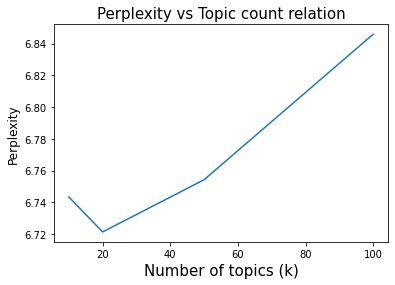

In [ ]:
import matplotlib.pylab as plt

lists = sorted(perplexity_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Number of topics (k)', fontsize=15)
plt.title('Perplexity vs Topic count relation', fontsize=15)
plt.show()

### Creating user clusters using LDA

In [ ]:
result_all_lda_20 = model_lda_k_20.transform(title_Count_15_lda)
result_all_lda_20.show(n=25, truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
result_all_lda_20.count()

ID                   135824
products             135824
features             135824
topicDistribution    135824
dtype: int64

In [ ]:
result_all_lda_20 = result_all_lda_20.toPandas()

In [ ]:
topic_dist_lda_20 = result_all_lda_20['topicDistribution']

In [ ]:
topic_dist_lda_20

0         [0.0009852565891537311, 0.000989068065646411, ...
1         [0.06510158359814627, 0.0003341191966780011, 0...
2         [0.0006435823656945042, 0.0006460720709991436,...
3         [0.5393768094647623, 0.006074592770672167, 0.0...
4         [0.0015091003786415395, 0.0015149383568635658,...
                                ...                        
135819    [0.0021958678452140058, 0.5147893143944405, 0....
135820    [0.0006033453736869903, 0.0006056794206812252,...
135821    [0.0010972838711093833, 0.0011015287184411246,...
135822    [0.176046730433944, 0.0017315595413147536, 0.1...
135823    [0.0005484795620299885, 0.0005506013628875747,...
Name: topicDistribution, Length: 135824, dtype: object

#### Plotting user 8 topic distributions, where topics consists of various products.

In [ ]:
abc = ((topic_dist_lda_20[:][8])).reshape(20,1)

In [ ]:
xyz = pd.DataFrame(abc)

In [ ]:
xyzw = xyz.rename(columns={0:"Dim"})

In [ ]:
xyzw

Dim
0   0.000380
1   0.000381
2   0.000379
3   0.000379
4   0.000380
5   0.000378
6   0.000378
7   0.992742
8   0.000393
9   0.000377
10  0.000376
11  0.000378
12  0.000376
13  0.000381
14  0.000385
15  0.000388
16  0.000391
17  0.000385
18  0.000382
19  0.000392

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


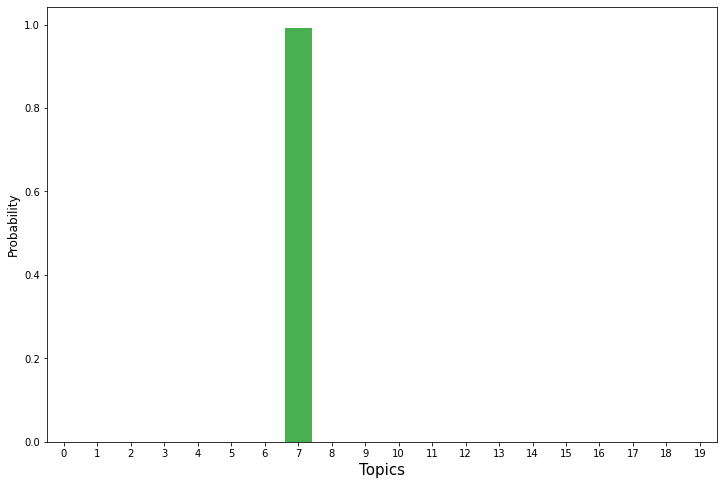

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(xyzw.index, xyzw.Dim)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Topics', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

#### Plotting user 13 topic distributions, where topics consists of various products.

In [ ]:
abc_13 = ((topic_dist_lda_20[:][13])).reshape(20,1)

In [ ]:
xyz_13 = pd.DataFrame(abc_13)

In [ ]:
xyzw_13 = xyz_13.rename(columns={0:"Dim"})

In [ ]:
xyzw_13

Dim
0   0.000754
1   0.000757
2   0.000752
3   0.000752
4   0.000755
5   0.000750
6   0.000750
7   0.985594
8   0.000780
9   0.000747
10  0.000746
11  0.000750
12  0.000746
13  0.000755
14  0.000765
15  0.000770
16  0.000776
17  0.000764
18  0.000759
19  0.000779

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


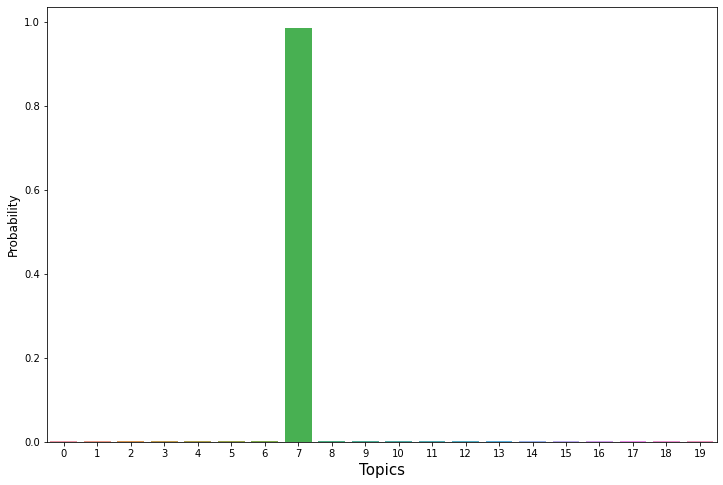

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(xyzw_13.index, xyzw_13.Dim)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Topics', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

#### Plotting user 1224 topic distributions, where topics consists of various products.

In [ ]:
abc_1224 = ((topic_dist_lda_20[:][1224])).reshape(20,1)
xyz_1224 = pd.DataFrame(abc_1224)
xyzw_1224 = xyz_1224.rename(columns={0:"Dim"})

In [ ]:
xyzw_1224

Dim
0   0.001509
1   0.001515
2   0.001505
3   0.001504
4   0.451006
5   0.001500
6   0.001500
7   0.001637
8   0.001561
9   0.001495
10  0.001492
11  0.001501
12  0.001492
13  0.001511
14  0.001530
15  0.001541
16  0.521595
17  0.001529
18  0.001518
19  0.001558

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


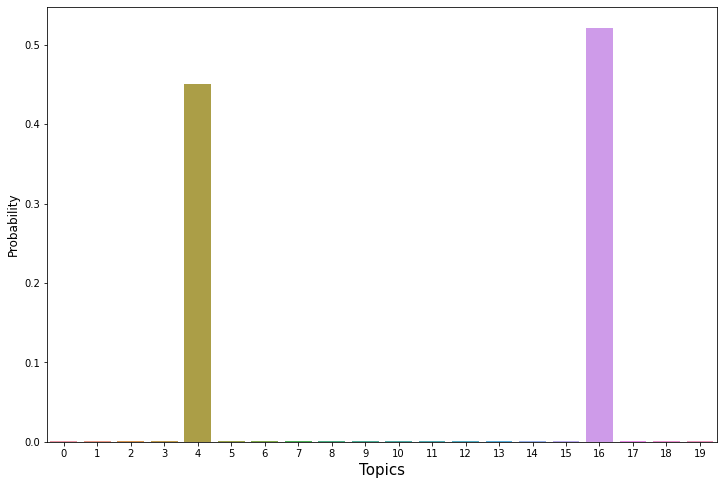

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(xyzw_1224.index, xyzw_1224.Dim)
plt.ylabel('Probability', fontsize=12)
plt.xlabel('Topics', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

#### Creating user clusters

In [ ]:
(topic_dist_lda_20[:][2])

DenseVector([0.0006, 0.0006, 0.3274, 0.0006, 0.0006, 0.0006, 0.0006, 0.3613, 0.3003, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0007, 0.0007, 0.0007, 0.0007, 0.0006, 0.0007])

In [ ]:
l=[]
for i in range(135824):
  l.append(np.argmax(topic_dist_lda_20[:][i]))

In [ ]:
(l)

In [ ]:
LDA_cluster_list = pd.DataFrame(l,columns=['prediction'])

In [ ]:
LDA_cluster_list

prediction
0               14
1                8
2                7
3                0
4                7
...            ...
135819           1
135820          15
135821          18
135822          17
135823           4

[135824 rows x 1 columns]

In [ ]:
# Already available
#user_list = pd.DataFrame(unique_user_15_cluster_orders_prod_name_df_refined['user_id'].unique(), columns = ['user_id'])

In [ ]:
user_list

user_id
0             2
1            10
2            16
3            32
4            35
...         ...
135819    59694
135820    72419
135821   112273
135822    30934
135823   116001

[135824 rows x 1 columns]

In [ ]:
user_clusters_LDA = pd.concat([user_list, LDA_cluster_list], axis=1)

In [ ]:
user_clusters_LDA

user_id  prediction
0             2          14
1            10           8
2            16           7
3            32           0
4            35           7
...         ...         ...
135819    59694           1
135820    72419          15
135821   112273          18
135822    30934          17
135823   116001           4

[135824 rows x 2 columns]

In [ ]:
user_count_each_LDA_cluster = user_clusters_LDA.groupby("prediction").count()
user_count_each_LDA_cluster

user_id
prediction         
0              2692
1              4375
2              1060
3              2057
4              4049
5              1485
6              1235
7             29790
8             11863
9               736
10              848
11             1019
12              653
13             3667
14            15404
15            12195
16            15356
17             6275
18             5481
19            15584

In [ ]:
import statistics
from statistics import mode
  
def most_common(List):
    return(mode(List))
    
#List = [2, 1, 2, 2, 1, 3]
most_common_l = most_common(l)
print(most_common_l)

7


In [ ]:
df1 = pd.DataFrame(result_all_lda_20)

In [ ]:
df1

ID  ...                                  topicDistribution
0            0  ...  [0.0009852565891537311, 0.000989068065646411, ...
1            1  ...  [0.06510158359814627, 0.0003341191966780011, 0...
2            2  ...  [0.0006435823656945042, 0.0006460720709991436,...
3            3  ...  [0.5393768094647623, 0.006074592770672167, 0.0...
4            4  ...  [0.0015091003786415395, 0.0015149383568635658,...
...        ...  ...                                                ...
135819  135819  ...  [0.0021958678452140058, 0.5147893143944405, 0....
135820  135820  ...  [0.0006033453736869903, 0.0006056794206812252,...
135821  135821  ...  [0.0010972838711093833, 0.0011015287184411246,...
135822  135822  ...  [0.176046730433944, 0.0017315595413147536, 0.1...
135823  135823  ...  [0.0005484795620299885, 0.0005506013628875747,...

[135824 rows x 4 columns]

In [ ]:
df4 = pd.concat([df1, user_list], axis=1)

In [ ]:
df4

ID  ... user_id
0            0  ...       2
1            1  ...      10
2            2  ...      16
3            3  ...      32
4            4  ...      35
...        ...  ...     ...
135819  135819  ...   59694
135820  135820  ...   72419
135821  135821  ...  112273
135822  135822  ...   30934
135823  135823  ...  116001

[135824 rows x 5 columns]

In [ ]:
user_indexes = [df4['user_id'][i] for i,x in enumerate(l) if x == most_common_l]

In [ ]:
df4['user_id'][0]

2

In [ ]:
user_indexes

[16,
 35,
 39,
 40,
 43,
 56,
 65,
 100,
 136,
 169,
 176,
 202,
 272,
 275,
 312,
 319,
 351,
 355,
 383,
 394,
 407,
 418,
 425,
 457,
 482,
 489,
 509,
 553,
 557,
 589,
 628,
 651,
 660,
 725,
 769,
 813,
 873,
 897,
 922,
 954,
 989,
 1037,
 1053,
 1113,
 1118,
 1129,
 1153,
 1163,
 1182,
 1208,
 1223,
 1226,
 1253,
 1258,
 1284,
 1302,
 1350,
 1385,
 1402,
 1417,
 1436,
 1448,
 1461,
 1499,
 1500,
 1511,
 1569,
 1603,
 1624,
 1630,
 1682,
 1787,
 1791,
 1792,
 1797,
 1826,
 1843,
 1857,
 1897,
 1915,
 1949,
 1998,
 2018,
 2026,
 2081,
 2121,
 2169,
 2189,
 2272,
 2279,
 2316,
 2338,
 2345,
 2353,
 2374,
 2379,
 2380,
 2385,
 2418,
 2451,
 2464,
 2490,
 2504,
 2513,
 2571,
 2578,
 2667,
 2673,
 2684,
 2705,
 2729,
 2758,
 2768,
 2772,
 2791,
 2797,
 2803,
 2846,
 2875,
 2877,
 2912,
 2913,
 2960,
 2963,
 2966,
 3027,
 3075,
 3091,
 3115,
 3138,
 3155,
 3165,
 3166,
 3173,
 3206,
 3227,
 3236,
 3239,
 3281,
 3303,
 3318,
 3355,
 3356,
 3369,
 3391,
 3487,
 3534,
 3552,
 3573,
 3585

In [ ]:
user_indexes_df = pd.DataFrame(user_indexes, columns =['user_id'])

In [ ]:
len(user_indexes_df['user_id'].unique())

29790

In [ ]:
user_indexes_df

user_id
0           16
1           35
2           39
3           40
4           43
...        ...
29785    34239
29786    41840
29787   160569
29788   100971
29789   161118

[29790 rows x 1 columns]

In [ ]:
unique_user_lda_cluster_df = user_indexes_df

In [ ]:
unique_user_lda_cluster_orders_df = unique_user_lda_cluster_df.merge(orders_df,how = 'inner',on = 'user_id')

In [ ]:
unique_user_lda_cluster_orders_df = unique_user_lda_cluster_orders_df[unique_user_lda_cluster_orders_df["eval_set"]=="prior"]

In [ ]:
unique_user_lda_cluster_orders_df

user_id  order_id  ... order_hour_of_day  days_since_prior_order
0            16   1273676  ...                 8                     NaN
1            16    875885  ...                13                    20.0
2            16   1491849  ...                20                    21.0
3            16   2704482  ...                14                    12.0
4            16   3192400  ...                14                    30.0
...         ...       ...  ...               ...                     ...
234723   100971   1151435  ...                 9                    20.0
234725   161118   2875545  ...                15                     NaN
234726   161118    510545  ...                 0                     8.0
234727   161118    159920  ...                12                    30.0
234728   161118    681562  ...                22                    30.0

[204940 rows x 7 columns]

In [ ]:
unique_user_lda_cluster_orders_prod_df = unique_user_lda_cluster_orders_df.merge(order_product_prior_df,how = 'inner', on = 'order_id')

In [ ]:
unique_user_lda_cluster_orders_prod_df

user_id  order_id eval_set  ...  product_id  add_to_cart_order  reordered
0             16   1273676    prior  ...       21903                  1          0
1             16   1273676    prior  ...       24852                  2          0
2             16   1273676    prior  ...       17794                  3          0
3             16   1273676    prior  ...       41950                  4          0
4             16   1273676    prior  ...       44359                  5          0
...          ...       ...      ...  ...         ...                ...        ...
2038646   161118   2875545    prior  ...       20776                  1          0
2038647   161118    510545    prior  ...       14309                  1          0
2038648   161118    159920    prior  ...       31222                  1          0
2038649   161118    681562    prior  ...       34643                  1          0
2038650   161118    681562    prior  ...        7088                  2          0

[2038651 rows x 10 columns]

In [ ]:
unique_user_lda_cluster_orders_prod_name_df = unique_user_lda_cluster_orders_prod_df.merge(products_df,how='left',on = 'product_id')

In [ ]:
unique_user_lda_cluster_orders_prod_name_df

user_id  order_id  ... aisle_id  department_id
0             16   1273676  ...      123              4
1             16   1273676  ...       24              4
2             16   1273676  ...       83              4
3             16   1273676  ...       83              4
4             16   1273676  ...       83              4
...          ...       ...  ...      ...            ...
2038646   161118   2875545  ...       63              9
2038647   161118    510545  ...      117             19
2038648   161118    159920  ...       98              7
2038649   161118    681562  ...      117             19
2038650   161118    681562  ...       78             19

[2038651 rows x 13 columns]

In [ ]:
unique_user_lda_cluster_orders_prod_name_df = unique_user_lda_cluster_orders_prod_name_df[["user_id","order_id","product_name"]]
unique_user_lda_cluster_orders_prod_name_df

user_id  order_id                                 product_name
0             16   1273676                         Organic Baby Spinach
1             16   1273676                                       Banana
2             16   1273676                                      Carrots
3             16   1273676                       Organic Tomato Cluster
4             16   1273676                   Organic Small Bunch Celery
...          ...       ...                                          ...
2038646   161118   2875545                               Organic Quinoa
2038647   161118    510545  Sprouted Pumpkin Seeds with Celtic Sea Salt
2038648   161118    159920                     100% Juice, Variety Pack
2038649   161118    681562                       Dry Roasted Macadamias
2038650   161118    681562                      Organic Cheddar Bunnies

[2038651 rows x 3 columns]

In [ ]:
len(unique_user_lda_cluster_orders_prod_name_df['product_name'].unique())

40928

In [ ]:
# frequency count of column A
count = unique_user_lda_cluster_orders_prod_name_df['product_name'].value_counts().reset_index()
count.columns= ["product_name","frequency_count"]

In [ ]:
#abc = count[count["frequency_count"]>177]
#abc

product_name  frequency_count
0                                                Banana            27861
1                                Bag of Organic Bananas            19977
2                                  Organic Baby Spinach            14464
3                                  Organic Strawberries            13098
4                                       Organic Avocado            11740
...                                                 ...              ...
2091                               Sourdough Deli Bread              178
2092  Fabric Softener Dryer Sheet Outdoor Fresh 160C...              178
2093    Natural Free & Clear Dishwasher Detergent Packs              178
2094                        Mighty Mango Juice Smoothie              178
2095              Grilled & Ready Chicken Breast Strips              178

[2096 rows x 2 columns]

In [ ]:
abc = count[count["frequency_count"]>600]
abc

product_name  frequency_count
0                                    Banana            27861
1                    Bag of Organic Bananas            19977
2                      Organic Baby Spinach            14464
3                      Organic Strawberries            13098
4                           Organic Avocado            11740
..                                      ...              ...
483                           Celery Sticks              604
484                           Honey Yoghurt              603
485                      Whole Strawberries              602
486  Macaroni Shells & White Cheddar Cheese              601
487            Vitamin D Organic Whole Milk              601

[488 rows x 2 columns]

20


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


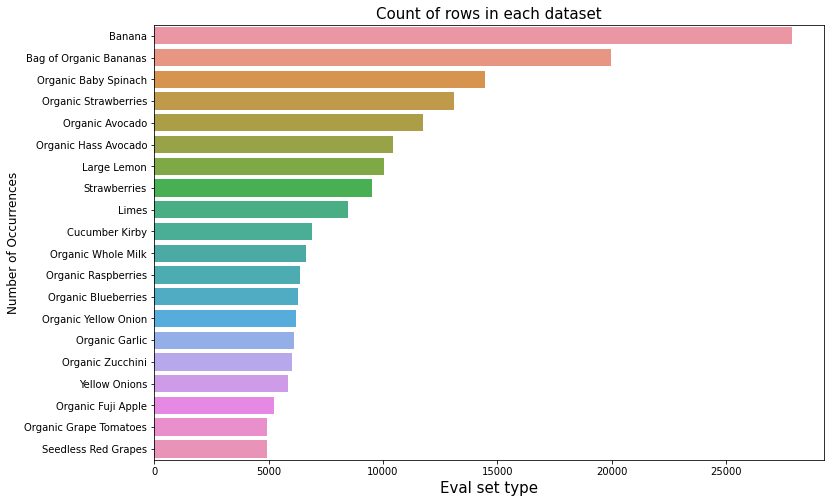

In [ ]:
import seaborn as sns

total_abc=abc.head(20)
print(len(total_abc["product_name"].unique()))

total_cnt_srs = total_abc
plt.figure(figsize=(12,8))
sns.barplot(total_cnt_srs.frequency_count, total_cnt_srs.product_name)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=15)
plt.title('Count of rows in each dataset', fontsize=15)
#plt.xticks(rotation='vertical')
plt.show()

In [ ]:
unique_user_lda_cluster_orders_prod_name_df_refined=pd.merge(unique_user_lda_cluster_orders_prod_name_df, abc, on='product_name', how='right')

In [ ]:
unique_user_lda_cluster_orders_prod_name_df_refined

user_id  order_id                  product_name  frequency_count
0            16   1273676                        Banana            27861
1            16   3192400                        Banana            27861
2            16   2000615                        Banana            27861
3            35   2562704                        Banana            27861
4            35    457048                        Banana            27861
...         ...       ...                           ...              ...
812369   201376   1001714  Vitamin D Organic Whole Milk              601
812370   205870     45480  Vitamin D Organic Whole Milk              601
812371    19034    206446  Vitamin D Organic Whole Milk              601
812372    49040    760700  Vitamin D Organic Whole Milk              601
812373   130159   2783952  Vitamin D Organic Whole Milk              601

[812374 rows x 4 columns]

In [ ]:
len(unique_user_lda_cluster_orders_prod_name_df_refined['order_id'].unique())

175432

In [ ]:
ordered_lda_product_name_df_basket = unique_user_lda_cluster_orders_prod_name_df_refined.groupby('user_id')['product_name'].apply(list)
ordered_lda_product_name_df_new_basket = ordered_lda_product_name_df_basket
ordered_lda_product_name_df_new_basket
user_baskets_lda = list(ordered_lda_product_name_df_new_basket)

In [ ]:
user_baskets_lda

[['Banana',
  'Banana',
  'Banana',
  'Organic Baby Spinach',
  'Organic Baby Spinach',
  'Organic Baby Spinach',
  'Organic Baby Spinach',
  'Organic Baby Spinach',
  'Organic Strawberries',
  'Organic Strawberries',
  'Organic Strawberries',
  'Organic Grape Tomatoes',
  'Organic Baby Arugula',
  'Michigan Organic Kale',
  'Michigan Organic Kale',
  'Organic Cucumber',
  'Carrots',
  'Carrots',
  'Fresh Cauliflower',
  'Organic Tomato Cluster',
  'Organic Tomato Cluster',
  'Organic Tomato Cluster',
  'Organic Tomato Cluster',
  'Organic Small Bunch Celery',
  'Organic Small Bunch Celery',
  'Organic Ginger Root',
  'Clementines, Bag',
  'Organic Spring Mix',
  'Frozen Organic Wild Blueberries',
  'Frozen Organic Wild Blueberries',
  'Frozen Organic Wild Blueberries',
  'Organic Red Radish, Bunch',
  'Organic Shredded Carrots',
  'Organic Unsalted Butter',
  'Globe Eggplant',
  'Globe Eggplant',
  'Tomato Paste',
  'Celery Hearts',
  'Organic Salted Butter',
  'Organic Salted Butter'

In [ ]:
len(user_baskets_lda)

29246

### Applying apriori algorithm to LDA user cluster product list

In [ ]:
import pandas as pd 
import seaborn as sns 
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import pickle

In [ ]:
te_in_lda = TransactionEncoder()
te_ary_insta_lda = te_in_lda.fit(user_baskets_lda).transform(user_baskets_lda)
insta_apriori_lda = pd.DataFrame(te_ary_insta_lda, columns=te_in_lda.columns_)
insta_apriori_lda

1% Low Fat Milk  ...  Yogurt, Strained Low-Fat, Coconut
0                False  ...                              False
1                False  ...                              False
2                False  ...                              False
3                False  ...                              False
4                False  ...                              False
...                ...  ...                                ...
29241            False  ...                              False
29242            False  ...                              False
29243            False  ...                              False
29244            False  ...                              False
29245            False  ...                              False

[29246 rows x 488 columns]

#### Support is kept as 0.05, so this means that the product which is included in the frequent itemset, constitutes to minimum 5% of the total orders.

In [ ]:
a_rules_lda = apriori(insta_apriori_lda, min_support = 0.05, use_colnames = True)

rules_after_lda_proper = association_rules(a_rules_lda, metric = 'confidence', min_threshold = 0.1)
rules_after_lda_proper

antecedents               consequents  ...  leverage  conviction
0                   (Banana)  (Bag of Organic Bananas)  ... -0.024732    0.904499
1   (Bag of Organic Bananas)                  (Banana)  ... -0.024732    0.871455
2     (Organic Baby Spinach)  (Bag of Organic Bananas)  ...  0.027996    1.211571
3   (Bag of Organic Bananas)    (Organic Baby Spinach)  ...  0.027996    1.171364
4     (Organic Hass Avocado)  (Bag of Organic Bananas)  ...  0.031019    1.380685
5   (Bag of Organic Bananas)    (Organic Hass Avocado)  ...  0.031019    1.176561
6     (Organic Strawberries)  (Bag of Organic Bananas)  ...  0.033063    1.267928
7   (Bag of Organic Bananas)    (Organic Strawberries)  ...  0.033063    1.207234
8                   (Banana)          (Cucumber Kirby)  ...  0.026301    1.106126
9           (Cucumber Kirby)                  (Banana)  ...  0.026301    1.502747
10                  (Banana)             (Large Lemon)  ...  0.028287    1.124291
11             (Large Lemon)                  (Banana)  ...  0.028287    1.310540
12                   (Limes)                  (Banana)  ...  0.019722    1.219149
13                  (Banana)                   (Limes)  ...  0.019722    1.082013
14         (Organic Avocado)                  (Banana)  ...  0.026932    1.305291
15                  (Banana)         (Organic Avocado)  ...  0.026932    1.116672
16                  (Banana)    (Organic Baby Spinach)  ...  0.012465    1.053873
17    (Organic Baby Spinach)                  (Banana)  ...  0.012465    1.093190
18                  (Banana)    (Organic Strawberries)  ...  0.013597    1.058650
19    (Organic Strawberries)                  (Banana)  ...  0.013597    1.105310
20            (Strawberries)                  (Banana)  ...  0.025754    1.304082
21                  (Banana)            (Strawberries)  ...  0.025754    1.110006
22           (Yellow Onions)                  (Banana)  ...  0.020078    1.342992
23                  (Banana)           (Yellow Onions)  ...  0.020078    1.079031
24                   (Limes)             (Large Lemon)  ...  0.036585    1.385851
25             (Large Lemon)                   (Limes)  ...  0.036585    1.336256
26         (Organic Avocado)             (Large Lemon)  ...  0.025207    1.223669
27             (Large Lemon)         (Organic Avocado)  ...  0.025207    1.212147
28    (Organic Baby Spinach)             (Large Lemon)  ...  0.019447    1.124917
29             (Large Lemon)    (Organic Baby Spinach)  ...  0.019447    1.166496
30                   (Limes)         (Organic Avocado)  ...  0.027265    1.259402
31         (Organic Avocado)                   (Limes)  ...  0.027265    1.241344
32                   (Limes)    (Organic Baby Spinach)  ...  0.022203    1.215514
33    (Organic Baby Spinach)                   (Limes)  ...  0.022203    1.142431
34         (Organic Avocado)    (Organic Baby Spinach)  ...  0.030385    1.300727
35    (Organic Baby Spinach)         (Organic Avocado)  ...  0.030385    1.208065
36         (Organic Avocado)    (Organic Strawberries)  ...  0.021285    1.191771
37    (Organic Strawberries)         (Organic Avocado)  ...  0.021285    1.141058
38    (Organic Baby Spinach)          (Organic Garlic)  ...  0.030938    1.197901
39          (Organic Garlic)    (Organic Baby Spinach)  ...  0.030938    1.514679
40    (Organic Hass Avocado)    (Organic Baby Spinach)  ...  0.026331    1.290046
41    (Organic Baby Spinach)    (Organic Hass Avocado)  ...  0.026331    1.171051
42    (Organic Strawberries)    (Organic Baby Spinach)  ...  0.031272    1.237612
43    (Organic Baby Spinach)    (Organic Strawberries)  ...  0.031272    1.228756
44    (Organic Strawberries)     (Organic Blueberries)  ...  0.028859    1.189623
45     (Organic Blueberries)    (Organic Strawberries)  ...  0.028859    1.416179
46    (Organic Hass Avocado)    (Organic Strawberries)  ...  0.027293    1.301324
47    (Organic Strawberries)    (Organic Hass Avocado)  ...  0.027293    1.183623

In [224]:
rules_after_lda_proper.sort_values(by=['confidence'])

antecedents               consequents  ...  leverage  conviction
0                   (Banana)  (Bag of Organic Bananas)  ... -0.024732    0.904499
23                  (Banana)           (Yellow Onions)  ...  0.020078    1.079031
8                   (Banana)          (Cucumber Kirby)  ...  0.026301    1.106126
1   (Bag of Organic Bananas)                  (Banana)  ... -0.024732    0.871455
13                  (Banana)                   (Limes)  ...  0.019722    1.082013
21                  (Banana)            (Strawberries)  ...  0.025754    1.110006
18                  (Banana)    (Organic Strawberries)  ...  0.013597    1.058650
16                  (Banana)    (Organic Baby Spinach)  ...  0.012465    1.053873
15                  (Banana)         (Organic Avocado)  ...  0.026932    1.116672
38    (Organic Baby Spinach)          (Organic Garlic)  ...  0.030938    1.197901
44    (Organic Strawberries)     (Organic Blueberries)  ...  0.028859    1.189623
33    (Organic Baby Spinach)                   (Limes)  ...  0.022203    1.142431
10                  (Banana)             (Large Lemon)  ...  0.028287    1.124291
28    (Organic Baby Spinach)             (Large Lemon)  ...  0.019447    1.124917
37    (Organic Strawberries)         (Organic Avocado)  ...  0.021285    1.141058
41    (Organic Baby Spinach)    (Organic Hass Avocado)  ...  0.026331    1.171051
5   (Bag of Organic Bananas)    (Organic Hass Avocado)  ...  0.031019    1.176561
47    (Organic Strawberries)    (Organic Hass Avocado)  ...  0.027293    1.183623
35    (Organic Baby Spinach)         (Organic Avocado)  ...  0.030385    1.208065
27             (Large Lemon)         (Organic Avocado)  ...  0.025207    1.212147
31         (Organic Avocado)                   (Limes)  ...  0.027265    1.241344
26         (Organic Avocado)             (Large Lemon)  ...  0.025207    1.223669
29             (Large Lemon)    (Organic Baby Spinach)  ...  0.019447    1.166496
3   (Bag of Organic Bananas)    (Organic Baby Spinach)  ...  0.027996    1.171364
36         (Organic Avocado)    (Organic Strawberries)  ...  0.021285    1.191771
30                   (Limes)         (Organic Avocado)  ...  0.027265    1.259402
7   (Bag of Organic Bananas)    (Organic Strawberries)  ...  0.033063    1.207234
32                   (Limes)    (Organic Baby Spinach)  ...  0.022203    1.215514
43    (Organic Baby Spinach)    (Organic Strawberries)  ...  0.031272    1.228756
42    (Organic Strawberries)    (Organic Baby Spinach)  ...  0.031272    1.237612
17    (Organic Baby Spinach)                  (Banana)  ...  0.012465    1.093190
25             (Large Lemon)                   (Limes)  ...  0.036585    1.336256
2     (Organic Baby Spinach)  (Bag of Organic Bananas)  ...  0.027996    1.211571
19    (Organic Strawberries)                  (Banana)  ...  0.013597    1.105310
40    (Organic Hass Avocado)    (Organic Baby Spinach)  ...  0.026331    1.290046
46    (Organic Hass Avocado)    (Organic Strawberries)  ...  0.027293    1.301324
34         (Organic Avocado)    (Organic Baby Spinach)  ...  0.030385    1.300727
6     (Organic Strawberries)  (Bag of Organic Bananas)  ...  0.033063    1.267928
24                   (Limes)             (Large Lemon)  ...  0.036585    1.385851
12                   (Limes)                  (Banana)  ...  0.019722    1.219149
45     (Organic Blueberries)    (Organic Strawberries)  ...  0.028859    1.416179
4     (Organic Hass Avocado)  (Bag of Organic Bananas)  ...  0.031019    1.380685
20            (Strawberries)                  (Banana)  ...  0.025754    1.304082
14         (Organic Avocado)                  (Banana)  ...  0.026932    1.305291
11             (Large Lemon)                  (Banana)  ...  0.028287    1.310540
39          (Organic Garlic)    (Organic Baby Spinach)  ...  0.030938    1.514679
22           (Yellow Onions)                  (Banana)  ...  0.020078    1.342992
9           (Cucumber Kirby)                  (Banana)  ...  0.026301    1.502747

## PCA on user segment, user as documents and products as dimensions

In [ ]:
# implementing PCA for k = 1000
pca = PCA(k=2095, inputCol="features", outputCol="pca_total_Count")
model_pca = pca.fit(title_Count_15_lda)

result_pca = model_pca.transform(title_Count_15_lda).select("pca_total_Count")

In [ ]:
result_pca

In [ ]:
# write your code here
m = model_pca.explainedVariance

# plotting code
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
ax.set_xlabel("K")
ax.set_ylabel("Eigen Value")
ax.plot(m, '-o')

In [ ]:
# write your code here
count = 1
K = 0
K_var = {}
total_var = 0
for i in m:
    total_var = total_var + i
    K_var[K] = total_var
    if total_var <= 0.90:
        count += 1
    K += 1

print("Number of components needed to explain around 90% of the total variance : ",(count))
    
K_var_list = list(K_var.values())
# plotting code
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.set_xlabel("K")
ax.set_ylabel("Total Variance Explained")
ax.plot(K_var_list, '-o')